In [ ]:
# Clone the GitHub repository
!git clone https://github.com/Shadow-Junaid/Image-recognition-for-medical-diagnosis.git

# Change directory to the cloned repository
%cd Image-recognition-for-medical-diagnosis

# List the contents of the directory
!ls


fatal: destination path 'Image-recognition-for-medical-diagnosis' already exists and is not an empty directory.
/content/Image-recognition-for-medical-diagnosis
README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2, Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess data
# Set the path for the dataset directory
base_dir = '/content/Image-recognition-for-medical-diagnosis'

# Define the paths for training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

            NORMAL  PNEUMONIA
Train         3312       8917
Validation     304        861
Test           171        411


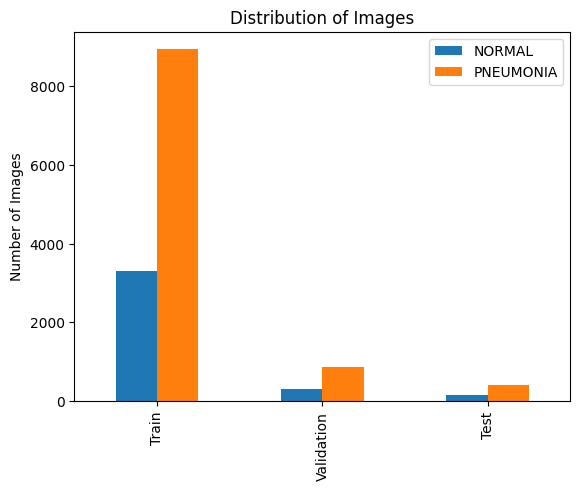

In [ ]:
# Function to count the number of images in each category
def count_images(directory):
    categories = ['NORMAL', 'PNEUMONIA']
    counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return counts

# Count images in each set
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Display the counts
data_counts = pd.DataFrame([train_counts, val_counts, test_counts], index=['Train', 'Validation', 'Test'])
print(data_counts)

# Plot the distribution of images
data_counts.plot(kind='bar', stacked=False)
plt.title('Distribution of Images')
plt.ylabel('Number of Images')
plt.show()

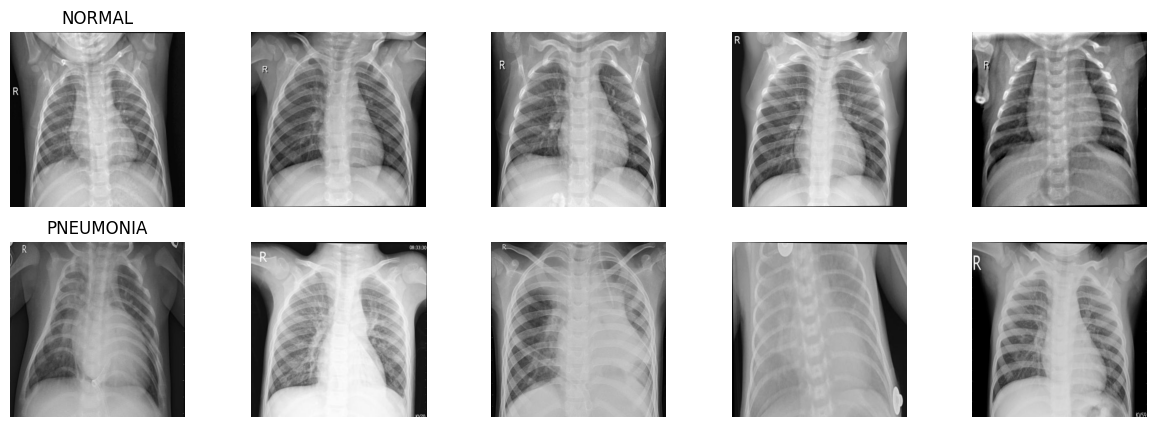

In [ ]:
import matplotlib.image as mpimg

# Function to plot example images from each category
def plot_example_images(directory, categories, num_images=5):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 5))
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        images = os.listdir(category_path)[:num_images]
        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)
    plt.show()

# Plot example images from the training set
plot_example_images(train_dir, ['NORMAL', 'PNEUMONIA'])


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 12229 images belonging to 2 classes.
Found 1165 images belonging to 2 classes.
Found 582 images belonging to 2 classes.


In [ ]:
# Initialize pre-trained models
def get_feature_extractor(model):
    base_model = model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

inception_resnet_v2_model = get_feature_extractor(InceptionResNetV2)
xception_model = get_feature_extractor(Xception)

# Extract features
def extract_features(model, generator):
    features = model.predict(generator, steps=len(generator), verbose=1)
    return features

X_train_inceptionresnet = extract_features(inception_resnet_v2_model, train_generator)
X_val_inceptionresnet = extract_features(inception_resnet_v2_model, val_generator)
X_test_inceptionresnet = extract_features(inception_resnet_v2_model, test_generator)

X_train_xception = extract_features(xception_model, train_generator)
X_val_xception = extract_features(xception_model, val_generator)
X_test_xception = extract_features(xception_model, test_generator)

# Combine features
X_train = np.hstack([X_train_inceptionresnet, X_train_xception])
X_val = np.hstack([X_val_inceptionresnet, X_val_xception])
X_test = np.hstack([X_test_inceptionresnet, X_test_xception])

y_train = train_generator.classes
y_val = val_generator.classes
y_test = test_generator.classes

19/19 [==============================] - 4s 215ms/step


In [ ]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.846165458937198, 1: 0.6857126836379949}


In [ ]:
# Dimensionality Reduction using Sparse Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 500  # Dimensionality reduction to 500

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_val, X_val))

X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

Epoch 1/50
48/48 [==============================] - 2s 14ms/step - loss: -19.5169 - val_loss: -76.7029
Epoch 2/50
48/48 [==============================] - 0s 9ms/step - loss: -207.6897 - val_loss: -429.0497
Epoch 3/50
48/48 [==============================] - 0s 9ms/step - loss: -695.0174 - val_loss: -1120.3505
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: -1504.0260 - val_loss: -2156.1963
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: -2633.1467 - val_loss: -3526.3848
Epoch 6/50
48/48 [==============================] - 0s 8ms/step - loss: -4074.5215 - val_loss: -5226.9399
Epoch 7/50
48/48 [==============================] - 0s 8ms/step - loss: -5823.9775 - val_loss: -7245.7588
Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: -7872.8179 - val_loss: -9583.0693
Epoch 9/50
48/48 [==============================] - 0s 8ms/step - loss: -10215.6309 - val_loss: -12229.8125
Epoch 10/50
48/48 [==============================]

In [ ]:
# Classification using Feed Forward Neural Network (FFNN)
ffnn = Sequential()
ffnn.add(Dense(1024, activation='relu', input_dim=encoding_dim))
ffnn.add(Dense(1, activation='sigmoid'))

ffnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = ffnn.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_data=(X_val_encoded, y_val), callbacks=[early_stopping])

Epoch 1/50
383/383 [==============================] - 4s 7ms/step - loss: 173.3924 - accuracy: 0.6054 - val_loss: 53.6765 - val_accuracy: 0.2609
Epoch 2/50
383/383 [==============================] - 2s 5ms/step - loss: 163.3065 - accuracy: 0.6168 - val_loss: 102.7423 - val_accuracy: 0.2609
Epoch 3/50
383/383 [==============================] - 1s 3ms/step - loss: 143.2589 - accuracy: 0.6081 - val_loss: 143.8853 - val_accuracy: 0.7391
Epoch 4/50
383/383 [==============================] - 1s 3ms/step - loss: 190.3905 - accuracy: 0.6009 - val_loss: 91.2872 - val_accuracy: 0.7391
Epoch 5/50
383/383 [==============================] - 1s 3ms/step - loss: 142.7278 - accuracy: 0.6018 - val_loss: 165.8815 - val_accuracy: 0.7391
Epoch 6/50
383/383 [==============================] - 2s 4ms/step - loss: 106.8220 - accuracy: 0.6022 - val_loss: 256.0263 - val_accuracy: 0.2609


19/19 [==============================] - 0s 2ms/step
Accuracy: 0.7061855670103093
AUC: 0.5
F1-Score: 0.8277945619335347
Precision: 0.7061855670103093
Specificity: 0.0
Sensitivity: 1.0
MCC: 0.0


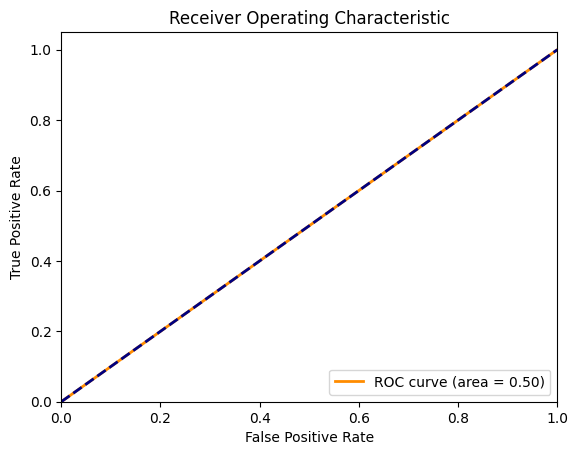

In [ ]:
# Evaluate on test set
y_test_pred_prob = ffnn.predict(X_test_encoded).flatten()
y_test_pred_class = (y_test_pred_prob > 0.5).astype(int)

# Compute metrics
test_accuracy = accuracy_score(y_test, y_test_pred_class)
test_f1_score = f1_score(y_test, y_test_pred_class)
test_auc_roc = roc_auc_score(y_test, y_test_pred_prob)
test_precision = precision_score(y_test, y_test_pred_class)
test_recall = recall_score(y_test, y_test_pred_class)  # Sensitivity
test_mcc = matthews_corrcoef(y_test, y_test_pred_class)

# Compute specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_class).ravel()
test_specificity = tn / (tn + fp)

# Print metrics
print(f'Accuracy: {test_accuracy}')
print(f'AUC: {test_auc_roc}')
print(f'F1-Score: {test_f1_score}')
print(f'Precision: {test_precision}')
print(f'Specificity: {test_specificity}')
print(f'Sensitivity: {test_recall}')
print(f'MCC: {test_mcc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Found 12229 images belonging to 2 classes.
Found 1165 images belonging to 2 classes.
Found 582 images belonging to 2 classes.
Class distribution: {0: 3312, 1: 8917}
19/19 [==============================] - 4s 217ms/step
Class weights: {0: 1.846165458937198, 1: 0.6857126836379949}
Epoch 1/50
383/383 [==============================] - 3s 4ms/step - loss: -2602.6750 - val_loss: -8834.6074
Epoch 2/50
383/383 [==============================] - 1s 4ms/step - loss: -19718.6289 - val_loss: -35973.8867
Epoch 3/50
383/383 [==============================] - 1s 4ms/step - loss: -52897.6758 - val_loss: -78959.8906
Epoch 4/50
383/383 [==============================] - 2s 4ms/step - loss: -100014.3359 - val_loss: -135689.0469
Epoch 5/50
383/383 [==============================] - 2s 4ms/step - loss: -159503.5156 - val_loss: -204967.1094
Epoch 6/50
383/383 [==============================] - 2s 5ms/step - loss: -230116.9531 - val_loss: -285402.6875
Epoch 7/50
383/383 [==============================] - 2

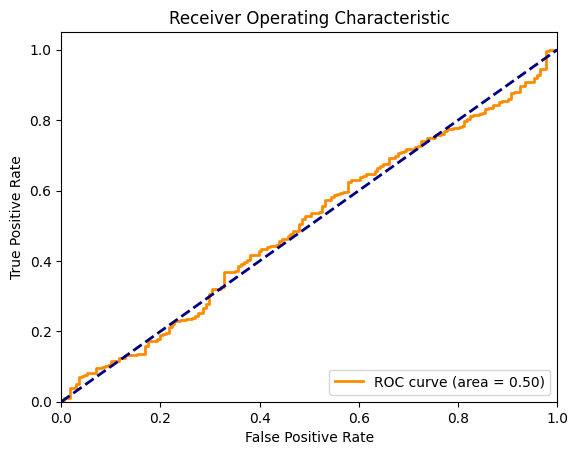

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2, Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Check class distribution
unique, counts = np.unique(train_generator.classes, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Initialize pre-trained models
def get_feature_extractor(model):
    base_model = model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

inception_resnet_v2_model = get_feature_extractor(InceptionResNetV2)
xception_model = get_feature_extractor(Xception)

# Extract features
def extract_features(model, generator):
    features = model.predict(generator, steps=len(generator), verbose=1)
    return features

X_train_inceptionresnet = extract_features(inception_resnet_v2_model, train_generator)
X_val_inceptionresnet = extract_features(inception_resnet_v2_model, val_generator)
X_test_inceptionresnet = extract_features(inception_resnet_v2_model, test_generator)

X_train_xception = extract_features(xception_model, train_generator)
X_val_xception = extract_features(xception_model, val_generator)
X_test_xception = extract_features(xception_model, test_generator)

# Combine features
X_train = np.hstack([X_train_inceptionresnet, X_train_xception])
X_val = np.hstack([X_val_inceptionresnet, X_val_xception])
X_test = np.hstack([X_test_inceptionresnet, X_test_xception])

y_train = train_generator.classes
y_val = val_generator.classes
y_test = test_generator.classes

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Dimensionality Reduction using Sparse Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 500  # Dimensionality reduction to 500

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_val, X_val))

X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

# Classification using Feed Forward Neural Network (FFNN)
ffnn = Sequential()
ffnn.add(Dense(1024, activation='relu', input_dim=encoding_dim))
ffnn.add(Dense(1, activation='sigmoid'))

ffnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = ffnn.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_data=(X_val_encoded, y_val), class_weight=class_weights, callbacks=[early_stopping])

# Evaluate on test set
y_test_pred_prob = ffnn.predict(X_test_encoded).flatten()
y_test_pred_class = (y_test_pred_prob > 0.5).astype(int)

# Compute metrics
test_accuracy = accuracy_score(y_test, y_test_pred_class)
test_f1_score = f1_score(y_test, y_test_pred_class)
test_auc_roc = roc_auc_score(y_test, y_test_pred_prob)
test_precision = precision_score(y_test, y_test_pred_class)
test_recall = recall_score(y_test, y_test_pred_class)  # Sensitivity
test_mcc = matthews_corrcoef(y_test, y_test_pred_class)

# Compute specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_class).ravel()
test_specificity = tn / (tn + fp)

# Print metrics
print(f'Accuracy: {test_accuracy}')
print(f'AUC: {test_auc_roc}')
print(f'F1-Score: {test_f1_score}')
print(f'Precision: {test_precision}')
print(f'Specificity: {test_specificity}')
print(f'Sensitivity: {test_recall}')
print(f'MCC: {test_mcc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/50
383/383 [==============================] - 47s 98ms/step - loss: 0.5919 - accuracy: 0.7292 - val_loss: 0.5740 - val_accuracy: 0.7391
Epoch 2/50
383/383 [==============================] - 34s 89ms/step - loss: 0.5877 - accuracy: 0.7292 - val_loss: 0.5774 - val_accuracy: 0.7391
Epoch 3/50
383/383 [==============================] - 38s 99ms/step - loss: 0.5873 - accuracy: 0.7292 - val_loss: 0.5736 - val_accuracy: 0.7391
Epoch 4/50
383/383 [==============================] - 34s 89ms/step - loss: 0.5880 - accuracy: 0.7292 - val_loss: 0.5741 - val_accuracy: 0.7391
Epoch 5/50
383/383 [==============================] - 35s 91ms/step - loss: 0.5881 - accuracy: 0.7292 - val_loss: 0.5780 - val_accuracy: 0.7391
Epoch 6/50
383/383 [==============================] - 35s 92ms/step - loss: 0.5855 - accuracy: 0.7292 - val_loss: 0.5735 - val_accuracy: 0.7391
Epoch 7/50
383/383 [==============================] - 34s 88ms/step - l

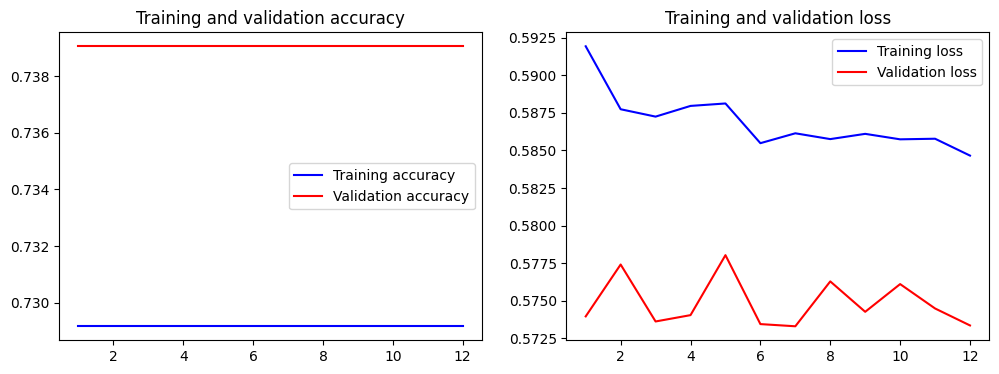

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
import numpy as np

# Load the EfficientNetB0 model pre-trained on ImageNet, excluding the top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # You can set a high number of epochs since EarlyStopping will halt training early if no improvement
    callbacks=[early_stopping]
)

# Plot training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)

# Get the ground truth labels and predicted probabilities
test_labels = test_generator.classes
test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
test_pred_labels = (test_predictions > 0.5).astype(int).flatten()

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_pred_labels)
test_f1_score = f1_score(test_labels, test_pred_labels)
test_auc_roc = roc_auc_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_pred_labels)
test_recall = recall_score(test_labels, test_pred_labels)  # Sensitivity
test_mcc = matthews_corrcoef(test_labels, test_pred_labels)

# Compute specificity
tn, fp, fn, tp = confusion_matrix(test_labels, test_pred_labels).ravel()
test_specificity = tn / (tn + fp)

# Print metrics
print(f'Accuracy: {test_accuracy}')
print(f'AUC: {test_auc_roc}')
print(f'F1-Score: {test_f1_score}')
print(f'Precision: {test_precision}')
print(f'Specificity: {test_specificity}')
print(f'Sensitivity: {test_recall}')
print(f'MCC: {test_mcc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Fine-tuning the model
# Unfreeze some layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback for fine-tuning
fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Continue training the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Set a high number of epochs since EarlyStopping will halt training early if no improvement
    callbacks=[fine_tune_early_stopping]
)

# Evaluate the fine-tuned model
fine_tune_loss, fine_tune_accuracy = model.evaluate(test_generator)
print(f'Fine-tuned Test Accuracy: {fine_tune_accuracy}')

# Get the ground truth labels and predicted probabilities after fine-tuning
fine_tune_test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
fine_tune_test_pred_labels = (fine_tune_test_predictions > 0.5).astype(int).flatten()

# Calculate metrics after fine-tuning
fine_tune_test_accuracy = accuracy_score(test_labels, fine_tune_test_pred_labels)
fine_tune_test_f1_score = f1_score(test_labels, fine_tune_test_pred_labels)
fine_tune_test_auc_roc = roc_auc_score(test_labels, fine_tune_test_predictions)
fine_tune_test_precision = precision_score(test_labels, fine_tune_test_pred_labels)
fine_tune_test_recall = recall_score(test_labels, fine_tune_test_pred_labels)  # Sensitivity
fine_tune_test_mcc = matthews_corrcoef(test_labels, fine_tune_test_pred_labels)

# Compute specificity after fine-tuning
tn, fp, fn, tp = confusion_matrix(test_labels, fine_tune_test_pred_labels).ravel()
fine_tune_test_specificity = tn / (tn + fp)

# Print fine-tuned metrics
print(f'Fine-tuned Test Accuracy: {fine_tune_test_accuracy}')
print(f'Fine-tuned F1 Score: {fine_tune_test_f1_score}')
print(f'Fine-tuned AUC-ROC: {fine_tune_test_auc_roc}')
print(f'Fine-tuned Precision: {fine_tune_test_precision}')
print(f'Fine-tuned Specificity: {fine_tune_test_specificity}')
print(f'Fine-tuned Sensitivity: {fine_tune_test_recall}')
print(f'Fine-tuned MCC: {fine_tune_test_mcc}')

# Plot ROC curve after fine-tuning
fpr, tpr, _ = roc_curve(test_labels, fine_tune_test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % fine_tune_test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Load dataset
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

# Load and preprocess data
# Set the path for the dataset directory
base_dir = '/content/Image-recognition-for-medical-diagnosis'

# Define the paths for training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

train_images, train_labels = load_images_from_folder(train_dir)
val_images, val_labels = load_images_from_folder(val_dir)
test_images, test_labels = load_images_from_folder(test_dir)

# Extract SIFT features
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            descriptors_list.append(des)
    return descriptors_list

train_descriptors = extract_sift_features(train_images)
val_descriptors = extract_sift_features(val_images)
test_descriptors = extract_sift_features(test_images)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Flatten the descriptors list
def flatten_descriptors(descriptors_list):
    all_descriptors = []
    for descriptors in descriptors_list:
        for des in descriptors:
            all_descriptors.append(des)
    return np.array(all_descriptors)

all_train_descriptors = flatten_descriptors(train_descriptors)

# KMeans clustering
num_clusters = 100  # You can choose a suitable number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(all_train_descriptors)

def construct_bovw(descriptors_list, kmeans):
    features = np.zeros((len(descriptors_list), num_clusters), dtype=np.float32)
    for i, descriptors in enumerate(descriptors_list):
        if descriptors is not None:
            clusters = kmeans.predict(descriptors)
            for cluster in clusters:
                features[i][cluster] += 1
    return features

train_features = construct_bovw(train_descriptors, kmeans)
val_features = construct_bovw(val_descriptors, kmeans)
test_features = construct_bovw(test_descriptors, kmeans)

# Standardize features
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, matthews_corrcoef

# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Train SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(train_features, train_labels_encoded)
svm_preds = svm.predict(test_features)
svm_probs = svm.predict_proba(test_features)[:, 1]

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, train_labels_encoded)
knn_preds = knn.predict(test_features)
knn_probs = knn.predict_proba(test_features)[:, 1]

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_features, train_labels_encoded)
rf_preds = rf.predict(test_features)
rf_probs = rf.predict_proba(test_features)[:, 1]

# Train Naive Bayes
nb = GaussianNB()
nb.fit(train_features, train_labels_encoded)
nb_preds = nb.predict(test_features)
nb_probs = nb.predict_proba(test_features)[:, 1]

# Evaluate classifiers
def evaluate_model(true_labels, pred_labels, pred_probs):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    auc_roc = roc_auc_score(true_labels, pred_probs)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    mcc = matthews_corrcoef(true_labels, pred_labels)

    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    specificity = tn / (tn + fp)

    return accuracy, f1, auc_roc, precision, recall, specificity, mcc

svm_metrics = evaluate_model(test_labels_encoded, svm_preds, svm_probs)
knn_metrics = evaluate_model(test_labels_encoded, knn_preds, knn_probs)
rf_metrics = evaluate_model(test_labels_encoded, rf_preds, rf_probs)
nb_metrics = evaluate_model(test_labels_encoded, nb_preds, nb_probs)

print("SVM Metrics: ", svm_metrics)
print("KNN Metrics: ", knn_metrics)
print("Random Forest Metrics: ", rf_metrics)
print("Naive Bayes Metrics: ", nb_metrics)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Prepare data for CNN
def prepare_data_for_cnn(images, labels):
    images_resized = [cv2.resize(img, (224, 224)) for img in images]
    images_array = np.array(images_resized)
    images_array = images_array.reshape(-1, 224, 224, 1).astype('float32') / 255.0
    labels_array = label_encoder.transform(labels)
    return images_array, labels_array

train_images_cnn, train_labels_cnn = prepare_data_for_cnn(train_images, train_labels)
val_images_cnn, val_labels_cnn = prepare_data_for_cnn(val_images, val_labels)
test_images_cnn, test_labels_cnn = prepare_data_for_cnn(test_images, test_labels)

# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_history = cnn_model.fit(train_images_cnn, train_labels_cnn, epochs=50, validation_data=(val_images_cnn, val_labels_cnn), callbacks=[early_stopping])

# Evaluate CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_images_cnn, test_labels_cnn)
cnn_preds = cnn_model.predict(test_images_cnn).flatten()
cnn_pred_labels = (cnn_preds > 0.5).astype(int)

cnn_metrics = evaluate_model(test_labels_cnn, cnn_pred_labels, cnn_preds)
print("CNN Metrics: ", cnn_metrics)


In [ ]:
# Summary of all models' metrics
models_metrics = {
    "SVM": svm_metrics,
    "KNN": knn_metrics,
    "Random Forest": rf_metrics,
    "Naive Bayes": nb_metrics,
    "CNN": cnn_metrics
}

for model_name, metrics in models_metrics.items():
    print(f"{model_name} Metrics: ")
    print(f"Accuracy: {metrics[0]}")
    print(f"F1 Score: {metrics[1]}")
    print(f"AUC-ROC: {metrics[2]}")
    print(f"Precision: {metrics[3]}")
    print(f"Sensitivity: {metrics[4]}")
    print(f"Specificity: {metrics[5]}")
    print(f"MCC: {metrics[6]}\n")
